# Astronomaly Testing Notebook

This notebook replicates the main feature extraction method of Astronomaly for optical data and is based on the DECaLS dataset. It can be used to inspect the step by step procedure of Astronomaly and is used for troubleshooting.

________

## 1. Modules and required functions

This section contains imports all the necessary modules and contains the functions used later on in the notebook.

In [69]:
import os
import cv2
import astropy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy import table
from astropy.stats import sigma_clipped_stats

In [70]:
def find_contours(img, threshold):
    """
    Finds the contours of an image that meet a threshold

    Parameters
    ----------
    img : np.ndarray
        Input image (must be greyscale)
    threshold : float
        What threshold to use

    Returns
    -------
    contours
        opencv description of contours (each contour is a list of x,y values
        and there may be several contours, given as a list of lists)
    hierarchy
        opencv description of how contours relate to each other (see opencv 
        documentation)
    """

    img_bin = np.zeros(img.shape, dtype=np.uint8)

    img_bin[img <= threshold] = 0
    img_bin[img > threshold] = 1

    contours,hierarchy = cv2.findContours(img_bin,
                            cv2.RETR_EXTERNAL, 
                            cv2.CHAIN_APPROX_SIMPLE)

    return contours, hierarchy

In [71]:
def get_ellipse_leastsq(contour, image):
    """
    Fits an ellipse to a (single) contour and returns the sum of the
    differences squared between the fitted ellipse and contour (normalised).

    Parameters
    ----------
    contour : np.ndarray
        Array of x,y values describing the contours (as returned by opencv's
        findCountours function)
    image : np.ndarray
        The original image the contour was fit to.

    Returns
    -------
    float
        sum((ellipse-contour)^2)/number_of_pixels
    """
    thickness = -1
    y_npix = image.shape[0]
    x_npix = image.shape[1]

    contour_arr = np.zeros([y_npix, x_npix], dtype=np.float)
    cv2.drawContours(contour_arr, [contour], 0, (1, 1, 1), thickness)

    ellipse_arr, params = fit_ellipse(contour, image, return_params=True)

    if np.any(np.isnan(params)):
        res = np.nan
    else:
        arr_diff = ellipse_arr - contour_arr
        res = np.sum((arr_diff)**2) / np.prod(contour_arr.shape)

    return [res] + list(params)

In [72]:
def fit_ellipse(contour, image, return_params=False):
    """
    Fits an ellipse to a contour and returns a binary image representation of
    the ellipse.

    Parameters
    ----------
    contour : np.ndarray
        Array of x,y values describing the contours (as returned by opencv's
        findCountours function)
    image : np.ndarray
        The original image the contour was fit to.
    return_params : bool
        If true also returns the parameters of the fitted ellipse

    Returns
    -------
    np.ndarray
        2d binary image with representation of the ellipse
    """

    thickness = 2
    y_npix = image.shape[0]
    x_npix = image.shape[1]
    ellipse_arr = np.zeros([y_npix, x_npix], dtype=np.float)

    # Sets some defaults for when the fitting fails
    default_return_params = [np.nan] * 5 
    raised_error = False

    try:
        ((x0, y0), (maj_axis, min_axis), theta) = cv2.fitEllipse(contour)
        ellipse_params = x0, y0, maj_axis, min_axis, theta

        if np.any(np.isnan(ellipse_params)):
            raised_error = True
            logging_tools.log('fit_ellipse failed with unknown error:')

    except cv2.error as e:
        logging_tools.log('fit_ellipse failed with cv2 error:' + e.msg)
        raised_error = True

    if raised_error:
        if return_params:
            return ellipse_arr, default_return_params
        else:
            return ellipse_arr

    x0 = int(np.round(x0))
    y0 = int(np.round(y0))
    maj_axis = int(np.round(maj_axis))
    min_axis = int(np.round(min_axis))
    theta = int(np.round(theta))

    cv2.ellipse(ellipse_arr, (x0, y0), (maj_axis // 2, min_axis // 2), 
                theta, 0, 360, (1, 1, 1), thickness)

    if return_params:
        return ellipse_arr, ellipse_params
    else:
        return ellipse_arr

________________________

## 2. Creating the catalogue

The tractor catalogue files downloaded from the DECaLS server have to be adjusted in order for Astronomaly to be able to use it. This section reads in a downloaded tractor file along with the corresponding image files and prepares them for Astronomaly to use. 

In [73]:
catalogue_file = '/home/verlon/Desktop/Astronomaly/Data/Input/Coadd_0260/0260m062/Catalogue/tractor-0260m062.fits'

In [74]:
image_file_g = '/home/verlon/Desktop/Astronomaly/Data/Input/Coadd_0260/0260m062/Images/g-legacysurvey-0260m062-image.fits.fz'
image_file_r = '/home/verlon/Desktop/Astronomaly/Data/Input/Coadd_0260/0260m062/Images/r-legacysurvey-0260m062-image.fits.fz'
image_file_z = '/home/verlon/Desktop/Astronomaly/Data/Input/Coadd_0260/0260m062/Images/z-legacysurvey-0260m062-image.fits.fz'

________________

### This is the function that creates a new catalogue ready for use with Astronomaly.
#### *NOTE: Point sources (PSF's) are removed here.*

In [75]:
def convert_tractor_catalogue(catalogue_file, image_file, image_name=''):
    """
    Converts a tractor fits file to a pandas dataframe to be given
    directly to an ImageDataset object.

    Parameters
    ----------
    catalogue_files : string
        tractor catalogue in fits table format 
    image_file:
        The image corresponding to this catalogue (to extract pixel information
        and naming information)
    """

    catalogue = astropy.table.Table(astropy.io.fits.getdata(catalogue_file,ignore_missing_end=True))

    dataframe = {}
    for name in catalogue.colnames:
        data = catalogue[name].tolist()
        dataframe[name] = data
    
    old_catalogue = pd.DataFrame(dataframe)
    hdul = astropy.io.fits.open(image_file)

    if len(image_name) == 0:
        original_image_ = image_file_g.split(os.path.sep)[-1]
        original_image = original_image_.replace(original_image_[:2],'')
    else:
        original_image = image_name
    
    #w = astropy.wcs.WCS(hdul[0].header, naxis=2)
    #x, y = w.wcs_world2pix(old_catalogue['ra'], old_catalogue['dec'], 1)
    
    new_catalogue = pd.DataFrame()
    new_catalogue['objid'] = old_catalogue['objid']
    new_catalogue['original_image'] = [original_image] * len(new_catalogue)
    new_catalogue['flux_g'] = old_catalogue['flux_g']
    new_catalogue['flux_r'] = old_catalogue['flux_r']
    new_catalogue['flux_z'] = old_catalogue['flux_z']
    new_catalogue['x'] = old_catalogue['bx'].astype('int')
    new_catalogue['y'] = old_catalogue['by'].astype('int')
    new_catalogue['ra'] = old_catalogue['ra']
    new_catalogue['dec'] = old_catalogue['dec']
    new_catalogue['type'] = old_catalogue['type']
    
    ## Removes PSFs
    catalogue_no_PSFs = new_catalogue[new_catalogue.type.astype("S") != b'PSF ']
    
    return new_catalogue

#### The new catalogue is created using the following command:

In [76]:
catalogue = convert_tractor_catalogue(catalogue_file, image_file_g)

This catalogue is ready to be used in Astronomaly. For the rest of this notebook this is not required.

______________________

## 3. Image Transformation

The images are transformed using the following functions. Combined they form the entire image transform function for the DECaLS dataset. It should be noted that the images transformed here are the cutouts of the objects contained within the datasets and are not the same as the images in the previous section.

In [77]:
image = '/home/verlon/Desktop/Astronomaly/Data/Input/Coadd_0260/0260m062/Failed Images/cutout_26.0835_-6.3682.fits'

In [78]:
image_data = fits.getdata(image)

The cutout.fits files contain the data of the images for the three different bands g,r and z. The different images are displayed below. Astonomaly uses the g-band by default

In [79]:
image_data_g = image_data[0]
image_data_r = image_data[1]
image_data_z = image_data[2]

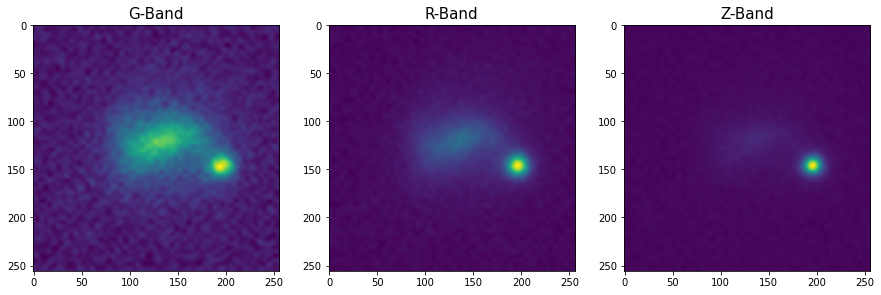

In [80]:
f = plt.figure(figsize = (15,15))
            
f.add_subplot(1,3, 1)
plt.imshow(image_data_g)
plt.gca().set_title('G-Band',fontsize = 15)

f.add_subplot(1,3, 2)
plt.imshow(image_data_r)
plt.gca().set_title('R-Band',fontsize = 15)

f.add_subplot(1,3, 3)
plt.imshow(image_data_z)
plt.gca().set_title('Z-Band',fontsize = 15)
            
plt.show(block=True)

____________

### Sigma Clipping

Sigma clipping is done to remove background noise as well as other objects that lie close to the central source. 

In [81]:
def image_transform_sigma_clipping(img, sigma=3, central=True):
    """
    Applies sigma clipping, fits contours and

    Parameters
    ----------
    img : np.ndarray
        Input image

    Returns
    -------
    np.ndarray

    """
    if len(img.shape) > 2:
        im = img[:, :, 0]
    else:
        im = img

    im = np.nan_to_num(im)  # OpenCV can't handle NaNs

    mean, median, std = sigma_clipped_stats(im, sigma=sigma)
    thresh = std + median
    img_bin = np.zeros(im.shape, dtype=np.uint8)

    img_bin[im <= thresh] = 0
    img_bin[im > thresh] = 1

    contours, hierarchy = cv2.findContours(img_bin, 
                                           cv2.RETR_EXTERNAL, 
                                           cv2.CHAIN_APPROX_SIMPLE)

    x0 = img.shape[0] // 2
    y0 = img.shape[1] // 2

    for c in contours:
        if cv2.pointPolygonTest(c, (x0, y0), False) == 1:
            break

    contour_mask = np.zeros_like(img, dtype=np.uint8)
    if len(contours) == 0:
        # This happens if there's no data in the image so we just return zeros
        return contour_mask
    cv2.drawContours(contour_mask, [c], 0, (1, 1, 1), -1)

    new_img = np.zeros_like(img)
    new_img[contour_mask == 1] = img[contour_mask == 1]

    return new_img

#### Results from the Sigma Clipping

In [82]:
img_g = image_transform_sigma_clipping(image_data_g)
img_r = image_transform_sigma_clipping(image_data_r)
img_z = image_transform_sigma_clipping(image_data_z)

The image displays the output after running the sigma clipping on the image.

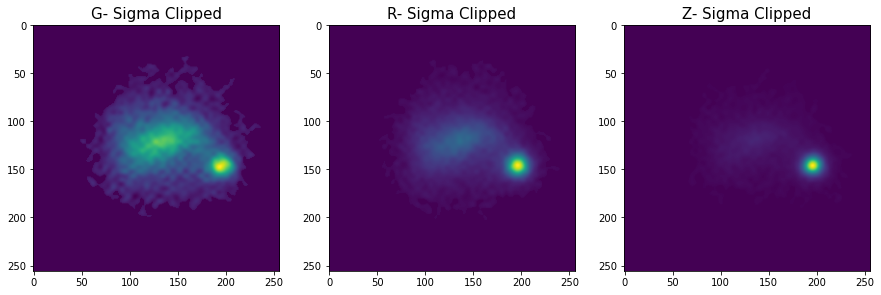

In [83]:
f = plt.figure(figsize = (15,15))
            
f.add_subplot(1,3, 1)
plt.imshow(img_g)
plt.gca().set_title('G- Sigma Clipped',fontsize = 15)

f.add_subplot(1,3, 2)
plt.imshow(img_r)
plt.gca().set_title('R- Sigma Clipped',fontsize = 15)

f.add_subplot(1,3, 3)
plt.imshow(img_z)
plt.gca().set_title('Z- Sigma Clipped',fontsize = 15)
            
plt.show(block=True)

### Scale Transform (Normalises the values)

The Scale Transform function normalises the values of the arrays so that they are between 0 and 1. This is useful for deep learning.

In [84]:
def image_transform_scale(img):
    """
    Small function to normalise an image between 0 and 1. Useful for deep 
    learning.

    Parameters
    ----------
    img : np.ndarray
        Input image

    Returns
    -------
    np.ndarray
        Scaled image

    """
    if img.min() == img.max():
        return img
    return (img - img.min()) / (img.max() - img.min())

#### Results from the Scale Transform

In [85]:
norm_img_g = image_transform_scale(img_g)
norm_img_r = image_transform_scale(img_r)
norm_img_z = image_transform_scale(img_z)

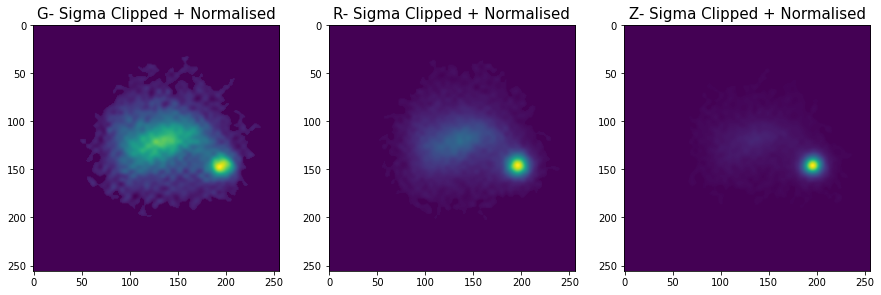

In [86]:
f = plt.figure(figsize = (15,15))
            
f.add_subplot(1,3, 1)
plt.imshow(norm_img_g)
plt.gca().set_title('G- Sigma Clipped + Normalised',fontsize = 15)

f.add_subplot(1,3, 2)
plt.imshow(norm_img_r)
plt.gca().set_title('R- Sigma Clipped + Normalised',fontsize = 15)

f.add_subplot(1,3, 3)
plt.imshow(norm_img_z)
plt.gca().set_title('Z- Sigma Clipped + Normalised',fontsize = 15)
            
plt.show(block=True)

_______________

## 4. Creating and fitting the contours and ellipses. 

This is the function that creates the contours and ellipses that is used by Astronomaly. The parameters of the ellipses are also returned.

In [87]:
def contours_and_ellipses(image, percentiles):

    x0 = y0 = -1
    x_cent = image.shape[0] // 2
    y_cent = image.shape[1] // 2
    
    feats = []
    all_contours = []
    all_ellipses = []
    all_parameters = []
    # Start with the closest in contour (highest percentile)
    percentiles = np.sort(percentiles)[::-1] 

    if np.all(image == 0):
        failed = True
        failure_message = "Invalid cutout for feature extraction"
    else:
        failed = False
        failure_message = ""

    for p in percentiles:
        if failed:
            contours = []
        else:
            thresh = np.percentile(image[image > 0], p)
            contours, hierarchy = find_contours(image, thresh)

            x_contours = np.zeros(len(contours))
            y_contours = np.zeros(len(contours))
            
            
        # First attempt to find the central point of the inner most contour
        #if len(contours[0]) != 0:
        if len(contours) != 0:
            for k in range(len(contours)):
                M = cv2.moments(contours[k])
                try:
                    x_contours[k] = int(M["m10"] / M["m00"])
                    y_contours[k] = int(M["m01"] / M["m00"])
                except ZeroDivisionError:
                    pass
            if x0 == -1:
                x_diff = x_contours - x_cent
                y_diff = y_contours - y_cent
            else:
                x_diff = x_contours - x0
                y_diff = y_contours - y0
                
            # Will try to find the CLOSEST contour to the central one
            r_diff = np.sqrt(x_diff**2 + y_diff**2)

            ind = np.argmin(r_diff)

            if x0 == -1:
                x0 = x_contours[ind]
                y0 = y_contours[ind]

            c = contours[ind]
        
            params = get_ellipse_leastsq(c, image)
            # Params return in this order:
            # residual, x0, y0, maj_axis, min_axis, theta
            if np.any(np.isnan(params)):
                failed = True
            else:
                if params[3] == 0 or params[4] == 0:
                    aspect = 1
                else:
                    aspect = params[4] / params[3]

                if aspect < 1:
                    aspect = 1 / aspect
                if aspect > 100:
                    aspect = 1                
                
                new_params = params[:3] + [aspect] + [params[-1]]
                feats.append(new_params)
        else:
            failed = True
            failure_message = "No contour found"

        if failed:
            feats.append([np.nan] * 5)
            logging_tools.log(failure_message)
            
        # Now we have the leastsq value, x0, y0, aspect_ratio, theta for each 
        # sigma
        # Normalise things relative to the highest threshold value
        # If there were problems with any sigma levels, set all values to NaNs
        if np.any(np.isnan(feats)):
            return [np.nan] * 4 * len(percentiles)
        else:
            max_ind = np.argmax(percentiles)

            residuals = []
            dist_to_centre = []
            aspect = []
            theta = []

            x0_max_sigma = feats[max_ind][1]
            y0_max_sigma = feats[max_ind][2]
            aspect_max_sigma = feats[max_ind][3]
            theta_max_sigma = feats[max_ind][4]

            for n in range(len(feats)):
                prms = feats[n]
                residuals.append(prms[0])
                if prms[1] == 0 or prms[2] == 0:
                    r = 0
                else:
                    x_diff = prms[1] - x0_max_sigma
                    y_diff = prms[2] - y0_max_sigma
                    r = np.sqrt((x_diff)**2 + (y_diff)**2)
                dist_to_centre.append(r)
                aspect.append(prms[3] / aspect_max_sigma)
                theta_diff = np.abs(prms[4] - theta_max_sigma) % 360
                # Because there's redundancy about which way an ellipse 
                # is aligned, we always take the acute angle
                if theta_diff > 90:
                    theta_diff -= 90
                theta.append(theta_diff)

            normalized_parameters = np.hstack((residuals, dist_to_centre, aspect, theta))
            
            
        thickness = 2
            
        y_npix = image.shape[0]
        x_npix = image.shape[1]
            
        contour_arr = np.zeros([y_npix, x_npix], dtype=np.float)
            
        arr = image.copy()
            
        cnt = cv2.drawContours(arr, [c], 0, (0.9, 0, 0), thickness)
            
        ellipse_arr, params = fit_ellipse(c, image, return_params=True)
        
        all_contours.append(cnt)
        all_ellipses.append(ellipse_arr)
        all_parameters.append(params)

        #print('Percentile is :' ,p)
        #print( 'Parameters are :' ,params)
            
        #f = plt.figure(figsize = (12,12))
            
        #f.add_subplot(1,2, 1)
        #plt.imshow(cnt, cmap='hot')

        #f.add_subplot(1,2, 2)
        #plt.imshow(ellipse_arr, cmap='hot')
            
        #plt.show(block=True)
    return (all_contours, all_ellipses,all_parameters)

______________

#### The function requires percentiles to be given which are used to separate the images into regions of different flux levels.
The percentiles are arbitrary in both amount and values.

In [88]:
percentiles = [90,80,70,60,50,0]

### Applying the function to obtain the contours and ellipses
The images on the left are the contours created based on the relevant percentile. To the right we have the best fit ellipse that matches this countour. The ellipse parameters and percentiles are also indicated to assist in troubleshooting.

In [89]:
contour, ellipse, parameters = contours_and_ellipses(norm_img_g, percentiles)

A single contour and ellipse can be drawn as follows:

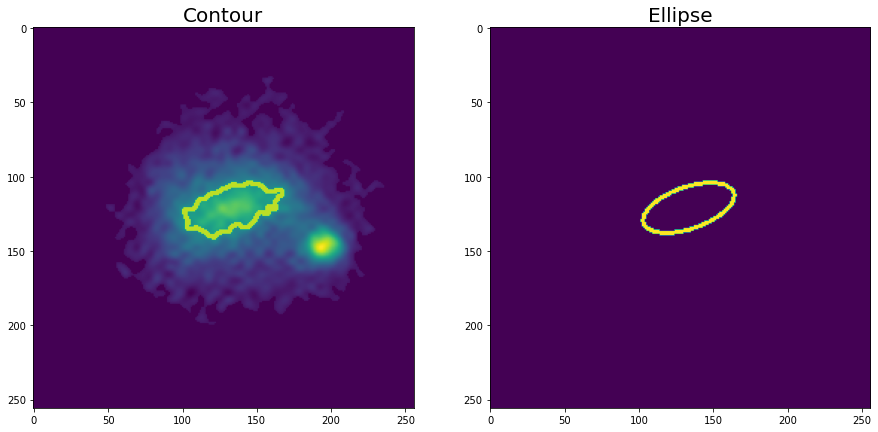

In [90]:
f = plt.figure(figsize = (15,15))

f.add_subplot(1,2, 1)
plt.imshow(contour[0])
plt.gca().set_title('Contour',fontsize = 20)

f.add_subplot(1,2, 2)
plt.imshow(ellipse[0])
plt.gca().set_title('Ellipse',fontsize = 20)
            
plt.show(block=True)

All of the contours and ellipses can be drawn as follows:

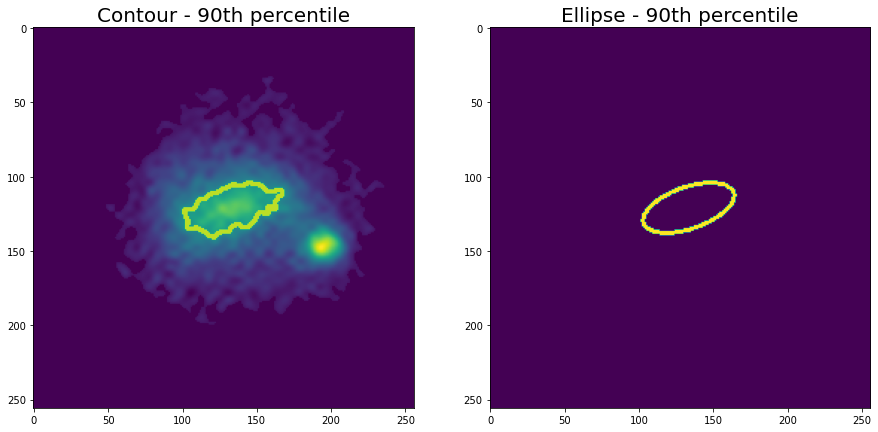

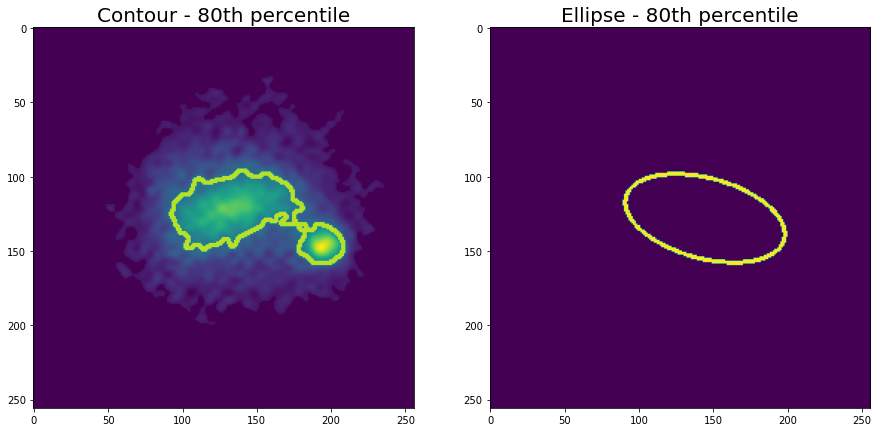

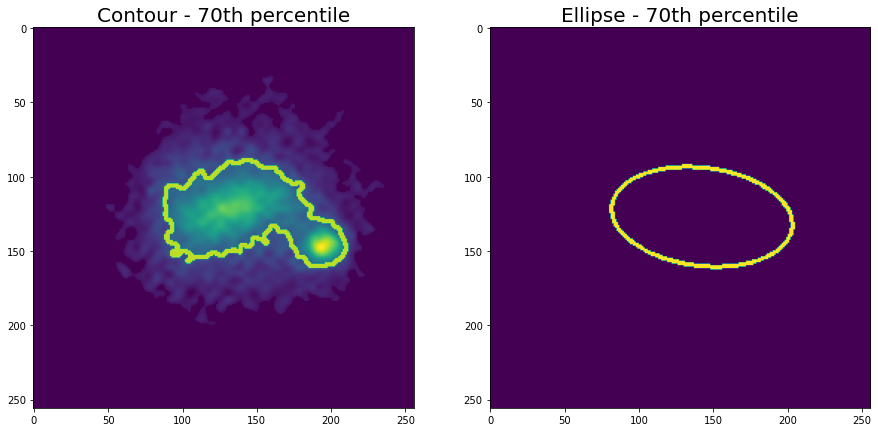

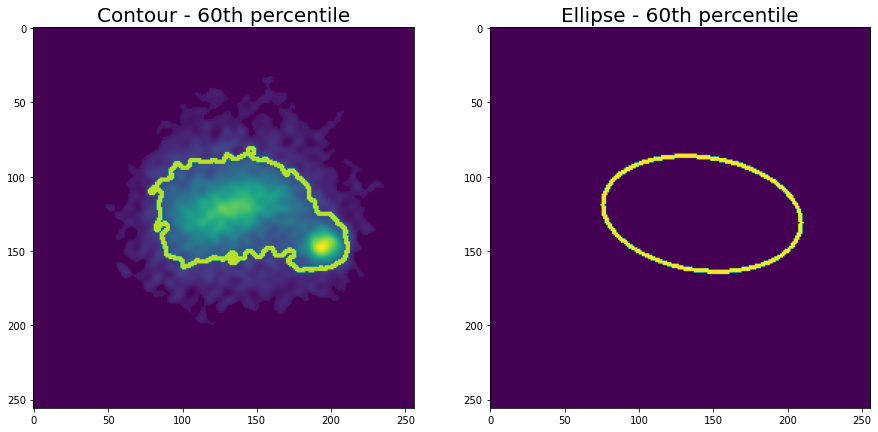

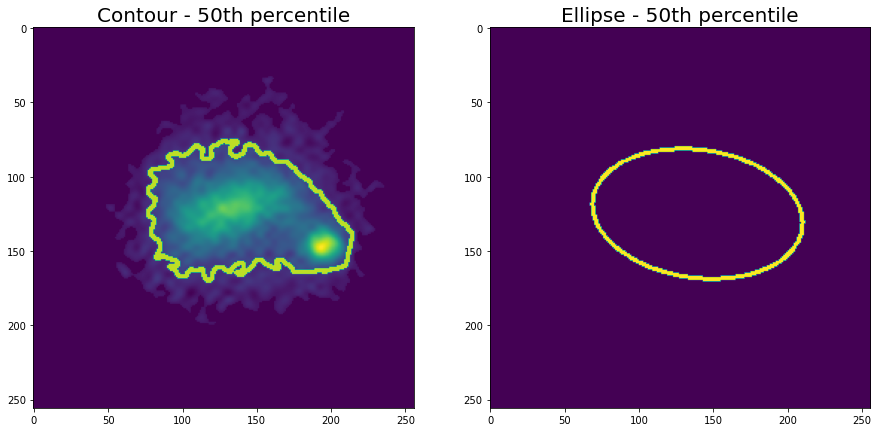

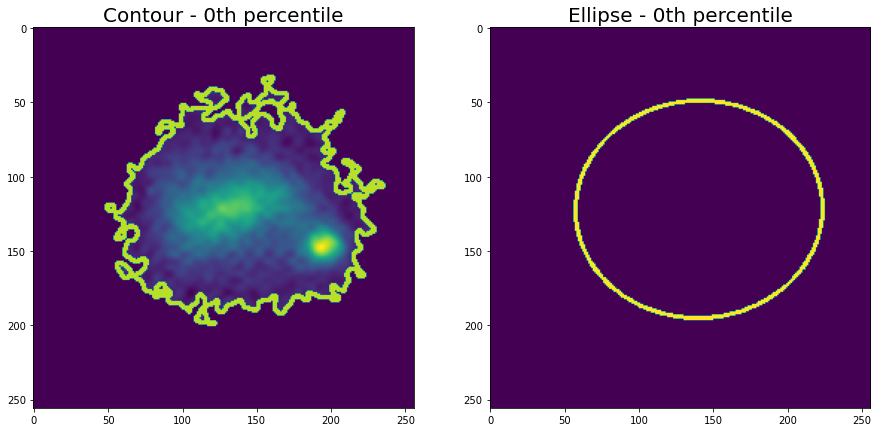

In [91]:
for p in range(len(percentiles)):
    
    f = plt.figure(figsize = (15,15))

    f.add_subplot(1,2, 1)
    plt.imshow(contour[p])
    plt.gca().set_title('Contour - ' +str(percentiles[p]) + 'th percentile',fontsize = 20)

    f.add_subplot(1,2, 2)
    plt.imshow(ellipse[p])
    plt.gca().set_title('Ellipse - ' +str(percentiles[p]) + 'th percentile',fontsize = 20)
            
    plt.show(block=True)

In [92]:
np.shape(contour[0])

(256, 256)

In [93]:
import astropy
import os
import xlsxwriter
import cv2
import tracemalloc
import io
import matplotlib as mpl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from astropy import io
from astropy.io import fits
from astropy import table
from astropy import wcs
from astropy.wcs import WCS
from skimage.transform import resize
from astronomaly.base.base_dataset import Dataset
from astronomaly.base import logging_tools
from astronomaly.data_management.image_reader import ImageDataset
from astronomaly.data_management import image_reader
from astronomaly.preprocessing import image_preprocessing
from astronomaly.feature_extraction import power_spectrum, autoencoder
from astronomaly.feature_extraction import shape_features
from astronomaly.dimensionality_reduction import pca
from astronomaly.postprocessing import scaling
from astronomaly.anomaly_detection import isolation_forest, human_loop_learning
from astronomaly.visualisation import tsne
from astronomaly.utils import utils
from astronomaly.data_management.image_reader import AstroImage

%matplotlib inline

In [94]:
def apply_transform(cutout, transform_function):
    """
    Applies the transform function(s) given at initialisation to the image.

    Parameters
    ----------
    cutout : np.ndarray
        Cutout of image

    Returns
    -------
    np.ndarray
        Transformed cutout
    """
    if transform_function is not None:
        try:
            len(transform_function)
            new_cutout = cutout
            for f in transform_function:
                new_cutout = f(new_cutout)
            cutout = new_cutout
        except TypeError:  # Simple way to test if there's only one function
            cutout = transform_function(cutout)
    return cutout

In [95]:
which_data = 'decals'

coadd_id = '026'

feature_method = 'ellipse'

dim_reduction = ''

band_prefixes = ['z-', 'r-', 'g-']

band_rgb = {'r': 'z-', 'g': 'r-', 'b': 'g-'}

image_transform_function = [image_preprocessing.image_transform_sigma_clipping,
                            # image_preprocessing.image_transform_inverse_sinh,
                            image_preprocessing.image_transform_scale
                            ]

display_transform_function = [#image_preprocessing.image_transform_inverse_sinh,
                              image_preprocessing.image_transform_scale]

plot_cmap = 'hot'
window_size = 32 # Changed this to match cutout array size
list_of_files = []

In [96]:
catalogue_file = '/home/verlon/Desktop/Astronomaly/Data/Input/Coadd_0260/0260m062/Catalogue/tractor-0260m062.fits'

image_file_g = '/home/verlon/Desktop/Astronomaly/Data/Input/Coadd_0260/0260m062/Images/g-legacysurvey-0260m062-image.fits.fz'
image_file_r = '/home/verlon/Desktop/Astronomaly/Data/Input/Coadd_0260/0260m062/Images/r-legacysurvey-0260m062-image.fits.fz'
image_file_z = '/home/verlon/Desktop/Astronomaly/Data/Input/Coadd_0260/0260m062/Images/z-legacysurvey-0260m062-image.fits.fz'

image_name = 'legacysurvey-0260m062-image.fits.fz'

df = convert_tractor_catalogue(catalogue_file, image_file_z, image_name='')

In [97]:
data_dir = '/home/verlon/Desktop/Astronomaly/Data/Input/Coadd_0260/0260m062/'
#data_dir = '/home/verlon/Desktop/Astronomaly/Data/Input/0267 Brick/'

image_dir = os.path.join(data_dir, 'Images')

output_dir = os.path.join(
    '/home/verlon/Desktop/Astronomaly/Data/Output/Coadd026','')

#output_dir = os.path.join(
#    '/home/verlon/Desktop/Astronomaly/Data/Output/0267 Brick', '')

#catalogue = '/home/verlon/Desktop/Astronomaly/Data/Input/Coadd_0260/0260m062/test_catalogue_0260m062_500.csv'
#cat = pd.read_csv(catalogue)
catalogue = df

In [98]:
image_dataset = image_reader.ImageDataset(directory=image_dir,
                                          list_of_files=list_of_files,
                                          window_size=window_size, 
                                          output_dir=output_dir, 
                                          plot_square=False,
                                          transform_function=image_transform_function,
                                          display_transform_function=display_transform_function,
                                          plot_cmap=plot_cmap,
                                          catalogue=df,
                                          band_prefixes=band_prefixes,
                                          bands_rgb=band_rgb)

Reading image data from /home/verlon/Desktop/Astronomaly/Data/Input/Coadd_0260/0260m062/Images/z-legacysurvey-0260m062-image.fits.fz...


2020-10-07 12:23:33,862 - WARNING - FITSFixedWarning: 'datfix' made the change 'Set DATE-REF to '1858-11-17' from MJD-REF'.


Done!
A catalogue of  8560 sources has been provided.


In [99]:
def get_image_data(idx, original_image):
    
    # Idx must be '...'
    
    images = []
    
    x0 = image_dataset.metadata.loc[idx, 'x']
    y0 = image_dataset.metadata.loc[idx, 'y']
    
    original_image = image_dataset.metadata.loc[idx, 'original_image']
    
    this_image = image_dataset.images[original_image]
    
    x_wid = image_dataset.window_size_x // 2
    y_wid = image_dataset.window_size_y // 2
    
    y_start = y0 - y_wid
    y_end = y0 + y_wid
    x_start = x0 - x_wid
    x_end = x0 + x_wid
    
    rs = y_start
    re = y_end
    cs = x_start
    ce = x_end
    this_image.fits_index
    
    
    
    

    for hdul in this_image.hdul_list:
        dat = hdul[this_image.fits_index].data

    image = dat[rs:re , cs:ce]
    images.append(image)
    image = images[0]
    #image.shape
    
    
    
    invalid_y = y_start < 0 or y_end > this_image.metadata['NAXIS1']
    invalid_x = x_start < 0 or x_end > this_image.metadata['NAXIS2']
        
    if invalid_y or invalid_x:
        cutout = np.ones((image_dataset.window_size_y, image_dataset.window_size_x)) * np.nan
    else:
        cutout = apply_transform(image, image_dataset.transform_function)
    if image_dataset.metadata.loc[idx, 'peak_flux'] == -1:
        if np.any(np.isnan(cutout)):
            flx = -1
        else:
            flx = np.max(cutout)
        image_dataset.metadata.loc[idx, 'peak_flux'] = flx

    #cutout = apply_transform(image, image_dataset.transform_function)
    
    
    
    #invalid_y = y_start < 0 or y_end > this_image.metadata['NAXIS1']
    #invalid_x = x_start < 0 or x_end > this_image.metadata['NAXIS2']
    #if invalid_y or invalid_x:
    #    cutout = np.ones((image_dataset.window_size_y, image_dataset.window_size_x)) * np.nan
    #else:
    #cutout = apply_transform(image, image_dataset.transform_function)
    #cutout.shape


    #f = plt.figure(figsize = (15,15))

    #f.add_subplot(1,2, 1)
    #plt.imshow(image)
    #plt.gca().set_title('Before Applying Transform Function',fontsize = 20)

    #f.add_subplot(1,2, 2)
    #plt.imshow(cutout)
    #plt.gca().set_title('After Applying Transform Function',fontsize = 20)
            
    #plt.show(block=True)
    
    return (cutout)

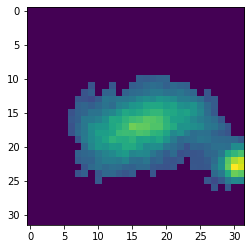

In [100]:
plt.imshow(get_image_data('66','original_image'))

In [101]:
contour, ellipse, parameters = contours_and_ellipses(get_image_data('66','original_image'), percentiles)

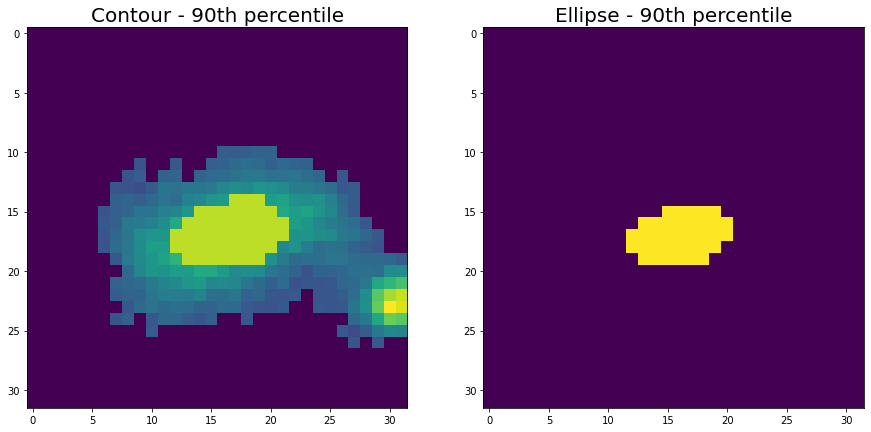

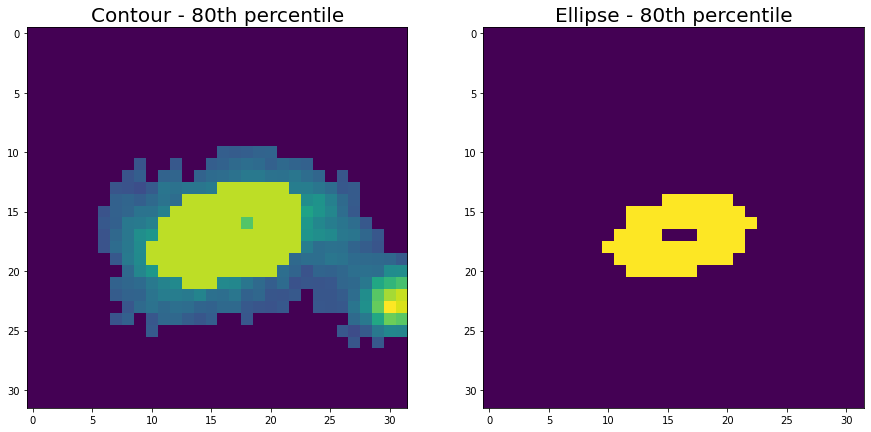

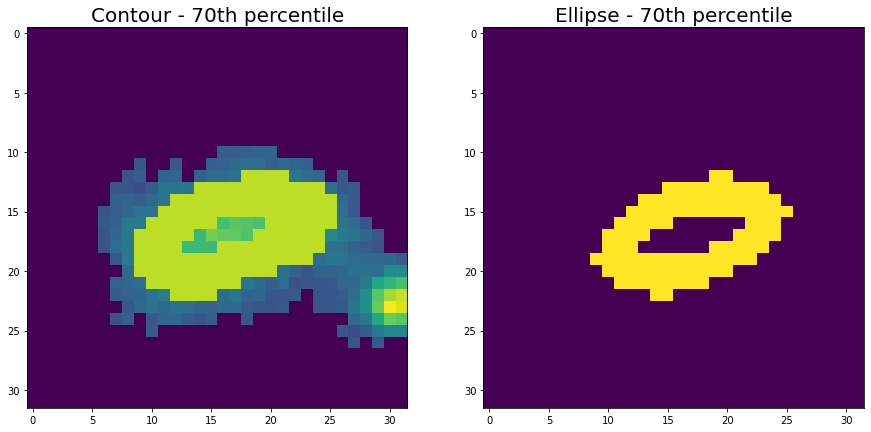

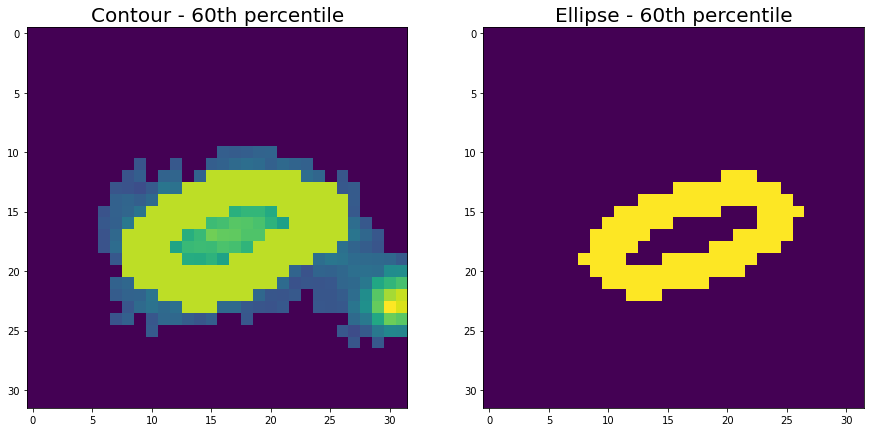

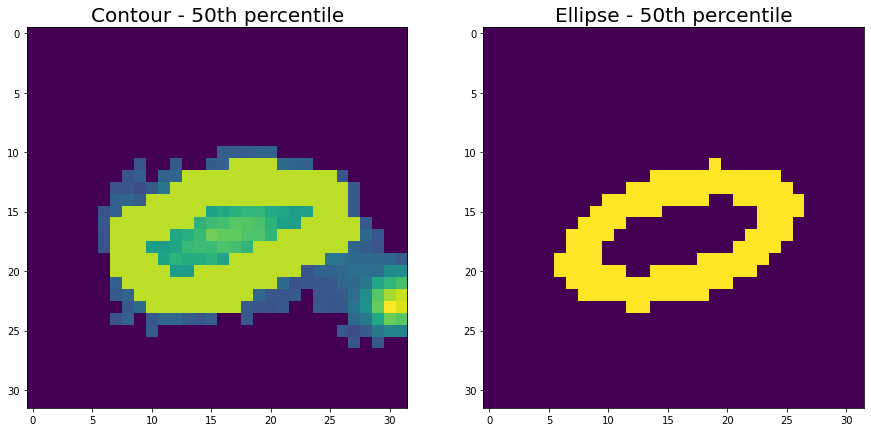

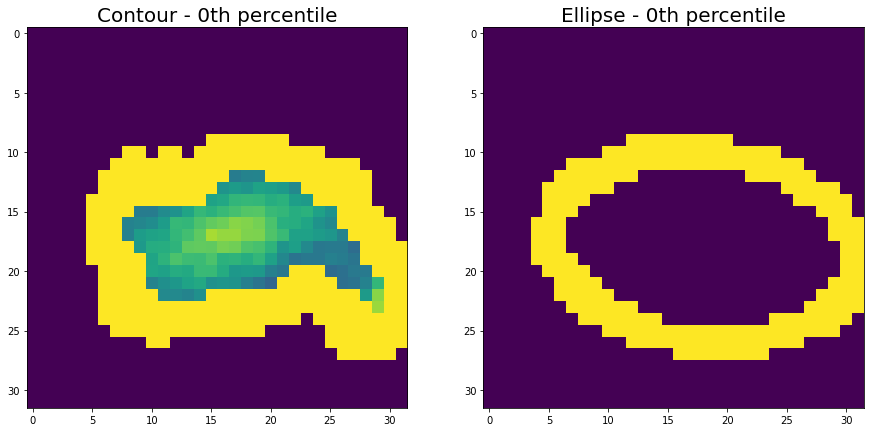

In [102]:
for p in range(len(percentiles)):
    
    f = plt.figure(figsize = (15,15))

    f.add_subplot(1,2, 1)
    plt.imshow(contour[p])
    plt.gca().set_title('Contour - ' +str(percentiles[p]) + 'th percentile',fontsize = 20)

    f.add_subplot(1,2, 2)
    plt.imshow(ellipse[p])
    plt.gca().set_title('Ellipse - ' +str(percentiles[p]) + 'th percentile',fontsize = 20)
            
    plt.show(block=True)